<a href="https://www.kaggle.com/code/fatemamoharam/spaceship-titanic?scriptVersionId=117970264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lazypredict.Supervised import LazyClassifier

In [93]:
# ! pip install lazypredict

# Read and explore the data

In [94]:
ROOT = '/kaggle/input/spaceship-titanic'
TRAIN = ROOT + '/' + 'train.csv'
TEST = ROOT + '/' + 'test.csv'

In [95]:
train_df = pd.read_csv(TRAIN)
test_df  = pd.read_csv(TEST)
train_df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [96]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [97]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


## Processing numerical columns

In [98]:
numCols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

Normalization

In [99]:
train_mean = {}
train_std = {}

for col in numCols:
    train_mean[col] = train_df[col].mean()
    train_std[col]  = train_df[col].std()

    train_df[col] = ( train_df[col] - train_df[col].mean() ) / train_df[col].std()
    test_df[col]  = ( test_df[col]  - train_df[col].mean() ) / train_df[col].std()

In [100]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,0.00,0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.99,-0.34,-0.28,-0.29,-0.27,-0.27
25%,-0.68,-0.34,-0.28,-0.29,-0.27,-0.27
50%,-0.13,-0.34,-0.28,-0.29,-0.27,-0.27
75%,0.63,-0.27,-0.24,-0.24,-0.22,-0.23
max,3.46,21.15,18.22,38.56,19.44,20.80


In [101]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
25%,19.00,-0.00,-0.00,0.00,-0.00,-0.00
50%,26.00,-0.00,-0.00,0.00,-0.00,-0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


## Processing Categorical Features

In [102]:
catCols = ['HomePlanet','Destination','Cabin','Name']

In [103]:
for col in catCols:
    print(f"{col} : \n {train_df[col].unique()}\n\n")

HomePlanet : 
 ['Europa' 'Earth' 'Mars' nan]


Destination : 
 ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


Cabin : 
 ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']


Name : 
 ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']




### Breaking 'Cabin' down

In [104]:
max_train = max(train_df.count())
max_test = max(test_df.count())

In [105]:
side = np.zeros((max_train),dtype=np.float32)
side_tst = np.zeros((max_test),dtype=np.float32)
for i, cabin in enumerate(train_df['Cabin'].values):
    if cabin:
        side[i] = 1 if str(cabin).split('/')[-1] == 'P' else 0
    else:
        side[i] = np.NaN
    
for i, cabin in enumerate(test_df['Cabin'].values):
    if cabin:
        side_tst[i] = 1 if str(cabin).split('/')[-1] == 'P' else 0
    else:
        side_tst[i] = np.NaN

In [106]:
num_cabin = np.zeros_like(side,dtype=np.float32)
num_cabin_tst = np.zeros_like(side_tst,dtype=np.float32)
for i, cabin in enumerate(train_df['Cabin'].values):
    try:
        num_cabin[i] = float(str(cabin).split('/')[1])
    except(IndexError):
        num_cabin[i] = np.NaN
    
for i, cabin in enumerate(test_df['Cabin'].values):
    try:
        num_cabin_tst[i] = float(str(cabin).split('/')[1])
    except(IndexError):
        num_cabin_tst[i] = np.NaN

In [107]:
deck = np.zeros_like(side,dtype=str)
deck_tst = np.zeros_like(side_tst,dtype=str)

for i, cabin in enumerate(train_df['Cabin'].values):
    try:
        deck[i] = str(cabin).split('/')[0]
    except(IndexError):
        deck[i] = 'NaN'
    
for i, cabin in enumerate(test_df['Cabin'].values):
    try:
        deck_tst[i] = str(cabin).split('/')[0]
    except(IndexError):
        deck_tst[i] = 'NaN'

In [108]:
side, num_cabin, deck

(array([1., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([   0.,    0.,    0., ..., 1500.,  608.,  608.], dtype=float32),
 array(['B', 'F', 'A', ..., 'G', 'E', 'E'], dtype='<U1'))

In [109]:
side_tst, num_cabin_tst, deck_tst

(array([0., 0., 0., ..., 1., 1., 0.], dtype=float32),
 array([   3.,    4.,    0., ...,  296.,  297., 1498.], dtype=float32),
 array(['G', 'F', 'C', ..., 'D', 'D', 'G'], dtype='<U1'))

In [110]:
col = 'Cabin Number'
num_cabin = pd.Series(num_cabin,name=col)
train_mean[col] = num_cabin.mean()
train_std[col] = num_cabin.std()

train_df[col] = ( num_cabin - num_cabin.mean() ) / num_cabin.std()
test_df[col] = ( num_cabin_tst - num_cabin.mean() ) / num_cabin.std()

In [111]:
train_df[col].describe()

count   8494.00
mean      -0.00
std        1.00
min       -1.17
25%       -0.85
50%       -0.34
75%        0.78
max        2.53
Name: Cabin Number, dtype: float64

In [112]:
test_df[col].describe()

count   4177.00
mean       0.02
std        1.01
min       -1.17
25%       -0.83
50%       -0.31
75%        0.83
max        2.52
Name: Cabin Number, dtype: float64

## One Hot Encoding

In [113]:
deck_df = pd.get_dummies(data=deck,prefix='Deck_',dummy_na=True)
home_df = pd.get_dummies(data=train_df['HomePlanet'],prefix='Home_',dummy_na=True)
dest_df = pd.get_dummies(data=train_df['Destination'],prefix='Dest_',dummy_na=True)
side_df = pd.get_dummies(data=side,prefix='Side_',dummy_na=True)



train_df = pd.concat([train_df.drop(['Cabin','HomePlanet','Destination'],axis=1),deck_df,home_df,dest_df],axis=1)

In [114]:
deck_df = pd.get_dummies(data=deck_tst,prefix='Deck_',dummy_na=True)
home_df = pd.get_dummies(data=test_df['HomePlanet'],prefix='Home_',dummy_na=True)
dest_df = pd.get_dummies(data=test_df['Destination'],prefix='Dest_',dummy_na=True)
side_df = pd.get_dummies(data=side_tst,prefix='Side_',dummy_na=True)


test_df = pd.concat([test_df.drop(['Cabin','HomePlanet','Destination'],axis=1),deck_df,home_df,dest_df],axis=1)

In [115]:
test_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin Number', 'Deck__A',
       'Deck__B', 'Deck__C', 'Deck__D', 'Deck__E', 'Deck__F', 'Deck__G',
       'Deck__T', 'Deck__n', 'Deck__nan', 'Home__Earth', 'Home__Europa',
       'Home__Mars', 'Home__nan', 'Dest__55 Cancri e', 'Dest__PSO J318.5-22',
       'Dest__TRAPPIST-1e', 'Dest__nan'],
      dtype='object')

In [116]:
train_df.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'Cabin Number',
       'Deck__A', 'Deck__B', 'Deck__C', 'Deck__D', 'Deck__E', 'Deck__F',
       'Deck__G', 'Deck__T', 'Deck__n', 'Deck__nan', 'Home__Earth',
       'Home__Europa', 'Home__Mars', 'Home__nan', 'Dest__55 Cancri e',
       'Dest__PSO J318.5-22', 'Dest__TRAPPIST-1e', 'Dest__nan'],
      dtype='object')

## Bool features

In [117]:
boolCols = ['CryoSleep','VIP','Transported']
for col in boolCols:
    train_df[col] = 1 * train_df[col].values 
    if col != 'Transported':
        test_df[col] = 1 * test_df[col].values

# Cleanup

In [118]:
train_df = train_df.drop(['Name','PassengerId'],axis=1)
test_id = test_df['PassengerId']
test_df = test_df.drop(['Name','PassengerId'],axis=1)

In [119]:
pd.Series(side)

0      1.00
1      0.00
2      0.00
3      0.00
4      0.00
       ... 
8688   1.00
8689   0.00
8690   0.00
8691   0.00
8692   0.00
Length: 8693, dtype: float32

In [120]:
train_df['Side'] = side
test_df['Side'] = side_tst

In [121]:
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin Number,...,Deck__nan,Home__Earth,Home__Europa,Home__Mars,Home__nan,Dest__55 Cancri e,Dest__PSO J318.5-22,Dest__TRAPPIST-1e,Dest__nan,Side
0,0,0.70,0,-0.34,-0.28,-0.29,-0.27,-0.27,0,-1.17,...,0,0,1,0,0,0,0,1,0,1.00
1,0,-0.33,0,-0.17,-0.28,-0.25,0.21,-0.23,1,-1.17,...,0,1,0,0,0,0,0,1,0,0.00
2,0,2.01,1,-0.27,1.93,-0.29,5.63,-0.22,0,-1.17,...,0,0,1,0,0,0,0,1,0,0.00
3,0,0.29,0,-0.34,0.51,0.33,2.65,-0.10,0,-1.17,...,0,0,1,0,0,0,0,1,0,0.00
4,0,-0.89,0,0.12,-0.24,-0.04,0.22,-0.26,1,-1.17,...,0,1,0,0,0,0,0,1,0,0.00


In [122]:
test_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin Number,Deck__A,...,Deck__nan,Home__Earth,Home__Europa,Home__Mars,Home__nan,Dest__55 Cancri e,Dest__PSO J318.5-22,Dest__TRAPPIST-1e,Dest__nan,Side
0,1,27.00,0,-0.00,-0.00,0.00,-0.00,-0.00,-1.17,0,...,0,1,0,0,0,0,0,1,0,0.00
1,0,19.00,0,-0.00,9.00,0.00,2823.00,-0.00,-1.17,0,...,0,1,0,0,0,0,0,1,0,0.00
2,1,31.00,0,-0.00,-0.00,0.00,-0.00,-0.00,-1.17,0,...,0,0,1,0,0,1,0,0,0,0.00
3,0,38.00,0,-0.00,6652.00,0.00,181.00,585.00,-1.17,0,...,0,0,1,0,0,0,0,1,0,0.00
4,0,20.00,0,10.00,-0.00,635.00,-0.00,-0.00,-1.16,0,...,0,1,0,0,0,0,0,1,0,0.00


In [123]:
test_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin Number,Deck__A,Deck__B,Deck__C,...,Deck__nan,Home__Earth,Home__Europa,Home__Mars,Home__nan,Dest__55 Cancri e,Dest__PSO J318.5-22,Dest__TRAPPIST-1e,Dest__nan,Side
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00,4177.00,4277.00,4277.00,4277.00,...,4277.00,4277.00,4277.00,4277.00,4277.00,4277.00,4277.00,4277.00,4277.00,4277.00
mean,28.66,219.27,439.48,177.30,303.05,310.71,0.02,0.02,0.08,0.08,...,0.00,0.53,0.23,0.22,0.02,0.20,0.09,0.69,0.02,0.49
std,14.18,607.01,1527.66,560.82,1117.19,1246.99,1.01,0.15,0.28,0.28,...,0.00,0.50,0.42,0.41,0.14,0.40,0.29,0.46,0.15,0.50
min,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-1.17,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.83,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.31,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00,0.83,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00,2.52,1.00,1.00,1.00,...,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Balancing data

In [124]:
train_df['Transported'].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [125]:
train_df = train_df.groupby('Transported')
train_df = train_df.apply(lambda x: x.sample(train_df.size().min()).reset_index(drop=True))

In [126]:
train_df['Transported'].value_counts()

0    4315
1    4315
Name: Transported, dtype: int64

In [127]:
y_train = train_df['Transported']
train_df = train_df.drop('Transported',axis=1)

In [128]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

## Data Splitting

In [129]:
 x_train, x_val, y_train, y_val = train_test_split(train_df.values, y_train.values, test_size = 0.15, random_state =1, stratify = y_train)

In [130]:
 x_train.shape, x_val.shape, y_train.shape, y_val.shape

((7335, 28), (1295, 28), (7335,), (1295,))

# Classifiers

In [131]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_val, y_train, y_val)
models

100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.82,0.82,0.82,0.82,2.87
NuSVC,0.82,0.82,0.82,0.82,3.72
XGBClassifier,0.81,0.81,0.81,0.81,1.04
LGBMClassifier,0.81,0.81,0.81,0.81,0.23
ExtraTreesClassifier,0.81,0.81,0.81,0.81,1.00
RandomForestClassifier,0.80,0.80,0.80,0.80,1.10
AdaBoostClassifier,0.80,0.80,0.80,0.80,0.46
LinearSVC,0.80,0.80,0.80,0.80,1.03
CalibratedClassifierCV,0.80,0.80,0.80,0.80,3.91


In [140]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       647
           1       0.81      0.83      0.82       648

    accuracy                           0.82      1295
   macro avg       0.82      0.82      0.82      1295
weighted avg       0.82      0.82      0.82      1295



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=150)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

In [141]:
y_pred = clf.predict(test_df.values)
sub = pd.DataFrame.from_dict({
    "PassengerId": test_id,
    "Transported": y_pred,
})
sub['Transported'] = sub['Transported'] == 1

sub.head()
sub.to_csv("/kaggle/working/submission.csv",index=False)

In [89]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       647
           1       0.83      0.75      0.79       648

    accuracy                           0.80      1295
   macro avg       0.80      0.80      0.80      1295
weighted avg       0.80      0.80      0.80      1295



In [42]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=40)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1079
           1       0.79      0.81      0.80      1079

    accuracy                           0.80      2158
   macro avg       0.80      0.80      0.80      2158
weighted avg       0.80      0.80      0.80      2158



In [43]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier([16,8],max_iter=2000)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

clf = MLPClassifier([32,16],max_iter=2000)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1079
           1       0.81      0.77      0.79      1079

    accuracy                           0.79      2158
   macro avg       0.79      0.79      0.79      2158
weighted avg       0.79      0.79      0.79      2158

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1079
           1       0.79      0.80      0.79      1079

    accuracy                           0.79      2158
   macro avg       0.79      0.79      0.79      2158
weighted avg       0.79      0.79      0.79      2158



In [44]:
clf = MLPClassifier([128,64],max_iter=2000)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1079
           1       0.78      0.81      0.79      1079

    accuracy                           0.79      2158
   macro avg       0.79      0.79      0.79      2158
weighted avg       0.79      0.79      0.79      2158



In [45]:
clf = MLPClassifier([8,4,2],max_iter=2000)
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1079
           1       0.82      0.80      0.81      1079

    accuracy                           0.81      2158
   macro avg       0.81      0.81      0.81      2158
weighted avg       0.81      0.81      0.81      2158



In [46]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79      1079
           1       0.82      0.71      0.76      1079

    accuracy                           0.78      2158
   macro avg       0.78      0.78      0.78      2158
weighted avg       0.78      0.78      0.78      2158



In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.95      0.17      0.28      1079
           1       0.54      0.99      0.70      1079

    accuracy                           0.58      2158
   macro avg       0.75      0.58      0.49      2158
weighted avg       0.75      0.58      0.49      2158



/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [48]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(SVC())
clf.fit(x_train,y_train)
print(classification_report(y_val,clf.predict(x_val)))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1079
           1       0.81      0.79      0.80      1079

    accuracy                           0.80      2158
   macro avg       0.80      0.80      0.80      2158
weighted avg       0.80      0.80      0.80      2158



# Deeplerning approach

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [133]:
LEARNING_RATE = 0.01
PATIENCE = 100
EPOCHS = 1000
CHK = '/kaggle/working/checkpoints/chk.h5'

In [134]:
values = np.linspace(0.00001,LEARNING_RATE,50)[::-1]
boundaries = np.linspace(5, EPOCHS,49)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience = PATIENCE, mode='min')

def configure_checkpoints(path):
    return keras.callbacks.ModelCheckpoint(
        filepath=path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [135]:
def train_and_plot(model,checkpoint_path,x_train,y_train,x_val,y_val,epochs=EPOCHS,batch_size=512):
    checkpoint = configure_checkpoints(checkpoint_path)
    history=model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val,y_val),
        callbacks=[lr_scheduler,checkpoint,early_stopping]
    )

    num=len(history.history['loss'])

    plt.plot(range(num),history.history['loss'],label = 'training loss')
    plt.plot(range(num),history.history['val_loss'],label = 'validation loss')

    plt.legend()

    plt.xlabel("Epochs ")
    plt.ylabel('Loss')

    plt.figure()

    plt.plot(range(num),history.history['accuracy'],label = 'training accuracy')
    plt.plot(range(num),history.history['val_accuracy'],label = 'validation accuracy')

    plt.legend()
    plt.xlabel("Epochs ")
    return history

In [136]:
model = keras.Sequential(
[
#     layers.Dropout(0.3,),
    layers.Dense(128,activation='tanh',input_shape=x_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(32,activation='tanh'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid',name='output')
], name='one-layer'
)
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

print(model.summary())

Model: "one-layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3712      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 33

2023-02-01 22:00:59.786725: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2023-02-01 22:00:59.994332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.01, shape=(), dtype=float64).
15/15 [==============================] - 2s 27ms/step - loss: 0.6392 - accuracy: 0.7155 - val_loss: 0.4552 - val_accuracy: 0.7915
Epoch 2/1000

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.01, shape=(), dtype=float64).
15/15 [==============================] - 0s 9ms/step - loss: 0.5020 - accuracy: 0.7617 - val_loss: 0.4461 - val_accuracy: 0.8100
Epoch 3/1000

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.01, shape=(), dtype=float64).
15/15 [==============================] - 0s 8ms/step - loss: 0.4665 - accuracy: 0.7843 - val_loss: 0.4344 - val_accuracy: 0.8062
Epoch 4/1000

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.01, shape=(), dtype=float64).
15/15 [==============================] - 0s 8ms/step - loss: 0.4534 - accuracy: 0.7932 - val_loss: 0.4487 - val_accuracy: 0.7753
Epoch 5/1000

Epoch

[0.35558074712753296, 0.8370656371116638]

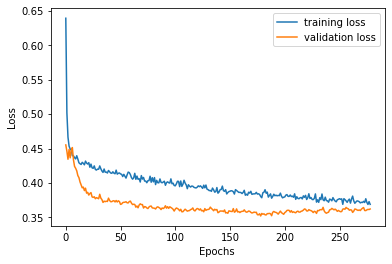

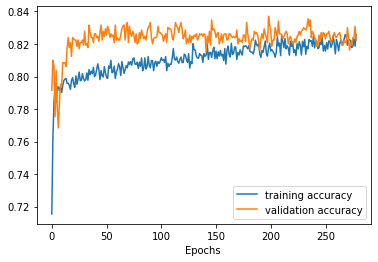

In [137]:
history = train_and_plot(
    model,
    CHK,
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=EPOCHS
)

model.load_weights(CHK)
model.evaluate(x_val,y_val)

In [139]:
y_pred = model.predict(test_df.values)
sub = pd.DataFrame.from_dict({
    "PassengerId": test_id,
    "Transported": y_pred.ravel(),
})
sub['Transported'] = sub['Transported'] == 1

sub.head()
sub.to_csv("/kaggle/working/submission.csv",index=False)